# GEOG5990M Final Assignment

Student ID number: 201725957

# **Title: Poverty and House Price Distribution in Leeds**

Many studies have shown that house prices in different regions are highly correlated with the standard of living and poverty levels of the population<a href="#ref1">[1]</a>. This phenomenon has been widely studied globally, especially in large cities with high housing costs. Housing costs account for a significant portion of total household expenditures, especially in large cities and economically developed regions. High house prices and rents lead to a reduction in the disposable income of low-income households, thereby increasing the risk of these households falling into poverty<a href="#ref2">[2]</a>. Housing policies play a key role in alleviating or exacerbating poverty. For example, studies in Australia and the United Kingdom have shown that social security and housing subsidies have been effective in reducing the pressure of housing costs on low-income households, but a large number of households still fall into "housing cost-induced poverty" as a result of high house prices<a href="#ref3">[3]</a>.

This project examines the correlation between regional poverty levels and housing prices, which will not only help to understand the mechanism of the impact of housing costs on poverty and provide a basis for the formulation of effective housing and social security policies, but will also provide a reference for regional development and urban planning, and promote balanced regional economic development.

The first step is to import the required packets

In [ ]:
# read in required packages
!pip install mapclassify
!pip install contextily
!pip install geoplot
!pip install matplotlib-scalebar

import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs

from sklearn.metrics import r2_score
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 25.0 MB/s eta 0:00:00


## **1. Data cleaning**

I created a GitHub repository to store the downloaded data.

Download "English_IMD_2019.zip" from the github repository using 'requests'. Use 'file.write(response.content)' to save the downloaded data to the folder.

In [ ]:
# Download IMD data from github
imd_zip_url = 'https://github.com/aOwOb/GEOG5990M_Final_Assignment_201725957/blob/ac9bc004dc3300577f02e1bae8a29f61a41465f2/Data/Poverty/English_IMD_2019.zip?raw=true'
imd_zip_path = 'English_IMD_2019.zip'

response = requests.get(imd_zip_url)
with open(imd_zip_path, 'wb') as file:
    file.write(response.content)

Use 'zipfile.ZipFile' to unzip the downloaded zip file. Use 'zip_ref.extractall' to save the unzipped file in a folder

In [ ]:
# Unzip the file
imd_extract_path = 'imd_data'

with zipfile.ZipFile(imd_zip_path, 'r') as zip_ref:
    zip_ref.extractall(imd_extract_path)

IMD data is from Consumer Data Research Centre<a href="#ref4">[4]</a>. 'The Index of Multiple Deprivation (IMD) datasets are small area measures of relative deprivation across each of the constituent nations of the United Kingdom. Areas are ranked from the most deprived area (rank 1) to the least deprived area.'<a href="#ref5">[5]</a> IMD data was collected in 2019 and the file is in shapfile format. IMD is an important indicator of regional poverty levels.

Use 'os.path.join' to build the file path. Use 'gpd.read_file' to read the Shapefile file and load it into the GeoDataFrame.

In the table, 'lsoa11cd' means lsoa code, 'lsoa11nm' means lsoa name, 'IMDScore' means IMD score, 'geometry' contains geographic information, which are the main data needed for this project.

In [ ]:
# Read IMD Shapefile
imd_shapefile_path = os.path.join(imd_extract_path, 'IMD_2019.shp')
imd_data = gpd.read_file(imd_shapefile_path)

imd_data.head()

lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

      st_areasha   st_lengths  IMD_Rank  IMD_Decile  \
0  133320.768872  2291.846072     29199           9   
1  226191.272990  2433.960112     30379          10   
2   57302.966538  1142.359799     14915           5   
3  190738.760504  2167.868343      8678           3   
4  144195.846857  1935.510354     14486           5   

                    LSOA01NM      LADcd                 LADnm  ...  IndDec  \
0        City of London 001A  E09000001        City of London  ...       5   
1        City of London 001B  E09000001        City of London  ...       7   
2        City of London 001C  E09000001        City of London  ...       6   
3        City of London 001E  E09000001        City of London  ...       8   
4  Barking and Dagenham 016A  E09000002  Barking and Dagenham  ...       5   

   OutScore  OutRank  OutDec  TotPop  DepChi  Pop16_59  Pop60+  WorkPop  \
0     1.503     1615       1    1296     175       656     465   715.00   
1     1.196     2969       1    1156     182       580     394   619.75   
2     2.207      162       1    1350     146       759     445   804.00   
3     1.769      849       1    1121     229       692     200   683.00   
4     0.969     4368       2    2040     522      1297     221  1284.50   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...  

[5 rows x 64 columns]

Filter out the required data.

In [ ]:
# Filtering data
imd_data_filtered = imd_data[['lsoa11cd', 'lsoa11nm', 'IMDScore', 'geometry']]

imd_data_filtered.head()

lsoa11cd                   lsoa11nm  IMDScore  \
0  E01000001        City of London 001A     6.208   
1  E01000002        City of London 001B     5.143   
2  E01000003        City of London 001C    19.402   
3  E01000005        City of London 001E    28.652   
4  E01000006  Barking and Dagenham 016A    19.837   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

As the study site for this project is Leeds, the rows containing 'Leeds' in the 'lsoa11nm' column were filtered by '.str.contains'

In [ ]:
# Filter rows containing "Leeds"
leeds_imd = imd_data_filtered[imd_data_filtered['lsoa11nm'].str.contains("Leeds", case=False, na=False)]

leeds_imd.head()

lsoa11cd    lsoa11nm  IMDScore  \
10947  E01011264  Leeds 011A    20.525   
10948  E01011265  Leeds 009A    13.602   
10949  E01011266  Leeds 008A     5.808   
10950  E01011267  Leeds 009B    27.863   
10951  E01011268  Leeds 010A    34.444   

                                                geometry  
10947  POLYGON ((421354.813 442327.406, 421423.688 44...  
10948  POLYGON ((418598.680 442761.477, 418637.561 44...  
10949  POLYGON ((417620.030 443437.088, 417810.760 44...  
10950  POLYGON ((419594.910 442295.179, 419657.752 44...  
10951  POLYGON ((420308.893 442013.704, 420322.898 44...

Use 'explore' for a simple visualization to observe IMD data distribution characteristics. 'column='IMDScore' specifies that the color mapping is to be based on the IMDScore column. cmap='spring' specifies that the color mapping variation is to be a gradient from purple to yellow. The reason for choosing this colormap is to a) make the map colors more distinguishable from the base map to highlight the map. b) This colormap was chosen with reference to accessible palettes<a href="#ref6">[6]</a>, which make the map colorblind friendly.'style_kwds' defines the boundary line style for the regions, in order to make the regions more visible.

In [ ]:
# Data visualization
leeds_imd.explore(column='IMDScore', cmap='spring', style_kwds=dict(color="black", weight=1, opacity=0.4))


House price data is sourced from the Consumer Data Research Centre, with data provided by the Valuation Office Agency (VOA) and the Office for National Statistics (ONS)<a href="#ref7">[7]</a>. The data contains median house prices for each region of the UK for the first quarter of 2020 and 2021.

In [ ]:
# Download house price data from github
house_price = pd.read_csv('https://raw.githubusercontent.com/aOwOb/GEOG5990M_Final_Assignment_201725957/main/Data/House_price/hpssa202103.csv')

house_price.head()

lsoacode  hpmd202003  hpmd202103
0  E01011949     95747.0     92692.0
1  E01011950     55862.0     47887.0
2  E01011951     57350.0     49176.0
3  E01011952     88317.0         NaN
4  E01011953    101061.0    137600.0

Since the imd data is for 2019, the house price data is selected for the more recent year 2020 as the data used in this study. Since the house price data is missing in some areas, I removed the rows with null values. To improve the readability of the data, I changed the variable name representing the house price in the original table from 'hpmd202003' to 'house_price'.

In [ ]:
# 筛选有用的并Remove null rows
house_price = house_price[['lsoacode', 'hpmd202003']]
house_price_1 = house_price.dropna()
house_price_1.rename(columns={'hpmd202003': 'house_price'}, inplace=True)

house_price_1.head()

<ipython-input-9-8deaf0c34833>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_price_1.rename(columns={'hpmd202003': 'house_price'}, inplace=True)


lsoacode  house_price
0  E01011949      95747.0
1  E01011950      55862.0
2  E01011951      57350.0
3  E01011952      88317.0
4  E01011953     101061.0

Combine two data together for follow-up study.

In [ ]:
# Merge two data
merged_data = pd.merge(leeds_imd, house_price_1, left_on='lsoa11cd', right_on='lsoacode', how='inner')

merged_data.head()

lsoa11cd    lsoa11nm  IMDScore  \
0  E01011264  Leeds 011A    20.525   
1  E01011265  Leeds 009A    13.602   
2  E01011266  Leeds 008A     5.808   
3  E01011267  Leeds 009B    27.863   
4  E01011268  Leeds 010A    34.444   

                                            geometry   lsoacode  house_price  
0  POLYGON ((421354.813 442327.406, 421423.688 44...  E01011264     225221.0  
1  POLYGON ((418598.680 442761.477, 418637.561 44...  E01011265     230759.0  
2  POLYGON ((417620.030 443437.088, 417810.760 44...  E01011266     366668.0  
3  POLYGON ((419594.910 442295.179, 419657.752 44...  E01011267     230935.0  
4  POLYGON ((420308.893 442013.704, 420322.898 44...  E01011268     167330.0

In [ ]:
# Check data
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lsoa11cd     470 non-null    object  
 1   lsoa11nm     470 non-null    object  
 2   IMDScore     470 non-null    float64 
 3   geometry     470 non-null    geometry
 4   lsoacode     470 non-null    object  
 5   house_price  470 non-null    float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 22.2+ KB


Use 'explore' for a simple visualization to observe house price data distribution characteristics. The map style is the same as in the previous article except for the colormap, in order to distinguish it from the previous map. And this colormap 'seismic' is also colorblind friendly.

In [ ]:
# Data visualization
merged_data.explore(column='house_price', cmap='seismic', style_kwds=dict(color="black", weight=1, opacity=0.4))

# 2. Regression Plot

The process of regression analysis and visualization:


1.   Use 'plt.figure' to create the drawing object and set the graphic size.
2.   Use 'sns.set' to set the style of Seaborn, including font scale and background style.
3.   Use 'sns.regplot' to plot the regression plot and set the style of the data points and regression lines.
4.   Use 'ax.set' to set the axis labels and title of the graph.
5.   Calculate the regression equation and R² score and add them as text to the chart.





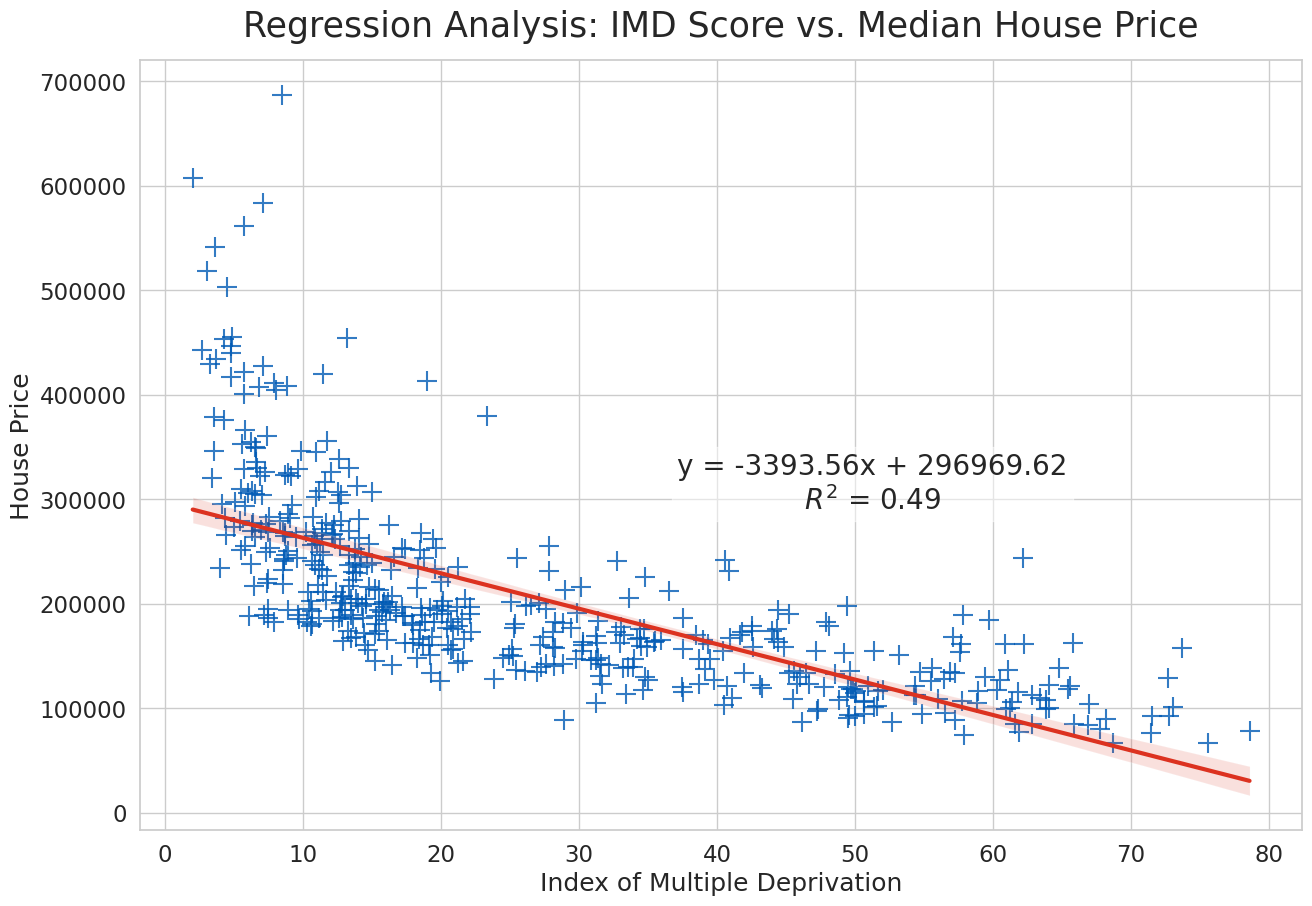

In [ ]:
# Creating plot frames
plt.figure(figsize=(15, 10))

# Set the style of Seaborn
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# Plot and style regression plots
ax = sns.regplot(x='IMDScore', y='house_price', data=merged_data, color='#005AB5', marker='+',
    scatter_kws={'s': 200},
    line_kws={'color': '#DC3220', 'linewidth': 3})

# Adjust the text and position of titles and labels
ax.set(xlabel='Index of Multiple Deprivation', ylabel='House Price')
ax.set_title('Regression Analysis: IMD Score vs. Median House Price', fontsize=25, y=1.02)

# Add the regression equation to the plot
# Perform linear regression
X = merged_data[['IMDScore']].values
Y = merged_data['house_price'].values

model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

# Calculate regression coefficients, intercepts and R² scores
coef = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(Y, Y_pred)

# Set the equation position
equation_text = f'y = {coef:.2f}x + {intercept:.2f}\n$R^2$ = {r2:.2f}'
ax.text(0.63, 0.45, equation_text, transform=ax.transAxes, fontsize=20, verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

This regression plot is largely based on the GDP of Canada plot <a href="#ref8">[8]</a> with some modifications. Firstly, setting the grid as the background not only provides a visual reference to make the plot more organized and enhances the readability of the plot, but also increases the hierarchy of the plot and improves the visual effect. Secondly, setting the marker style to '+' has higher clarity, reduces overlap when the data points are dense, and keeps the data points recognizable. The markers and line colormaps were chosen to use '#005AB5' and '#DC3220' not only because their high contrast improves readability, but also with reference to Coloring for Colorblindness<a href="#ref6">[6]</a>, which helps with accessibility. When setting the title and label, the position was adjusted to avoid the text being too close to the image. In addition, adding the regression equations to the graphs increases the information content of the graphs by visualizing the quantitative relationships between the variables.

# 3. Spatial maps

I chose to use a combination of choropleth map and proportional symbols map to create a spatial map. proportional symbols map is needed to find the center of mass of each area. Use '.centroid' to extract the center of mass of the region.

In [ ]:
# copy the countries dataframe
merged_data_centroid = merged_data.copy()

# calcualte the centorid and replace the country geometry (polygon) with the centroid geometry (point)
merged_data_centroid['geometry'] = merged_data.centroid

# check - geometry should contain point data
merged_data_centroid.head()

lsoa11cd    lsoa11nm  IMDScore                       geometry   lsoacode  \
0  E01011264  Leeds 011A    20.525  POINT (420974.957 441899.804)  E01011264   
1  E01011265  Leeds 009A    13.602  POINT (419006.591 442024.830)  E01011265   
2  E01011266  Leeds 008A     5.808  POINT (417411.944 442510.441)  E01011266   
3  E01011267  Leeds 009B    27.863  POINT (419682.669 442015.885)  E01011267   
4  E01011268  Leeds 010A    34.444  POINT (420185.033 441807.648)  E01011268   

   house_price  
0     225221.0  
1     230759.0  
2     366668.0  
3     230935.0  
4     167330.0

The process of map creating:


1.   Use '. to_crs' to set the coordinate reference system
2.   set plot frame and set its dimensions.
3.   Plot choropleth map based on IMD Score and set the block style.
4.   Add CartoDB basemap.
5.   Plot proportional symbol map based on house price and set the point style.
6.   Add Scale and set its position.
7.   Add a North Pointer.
8.   Set Legend and Title

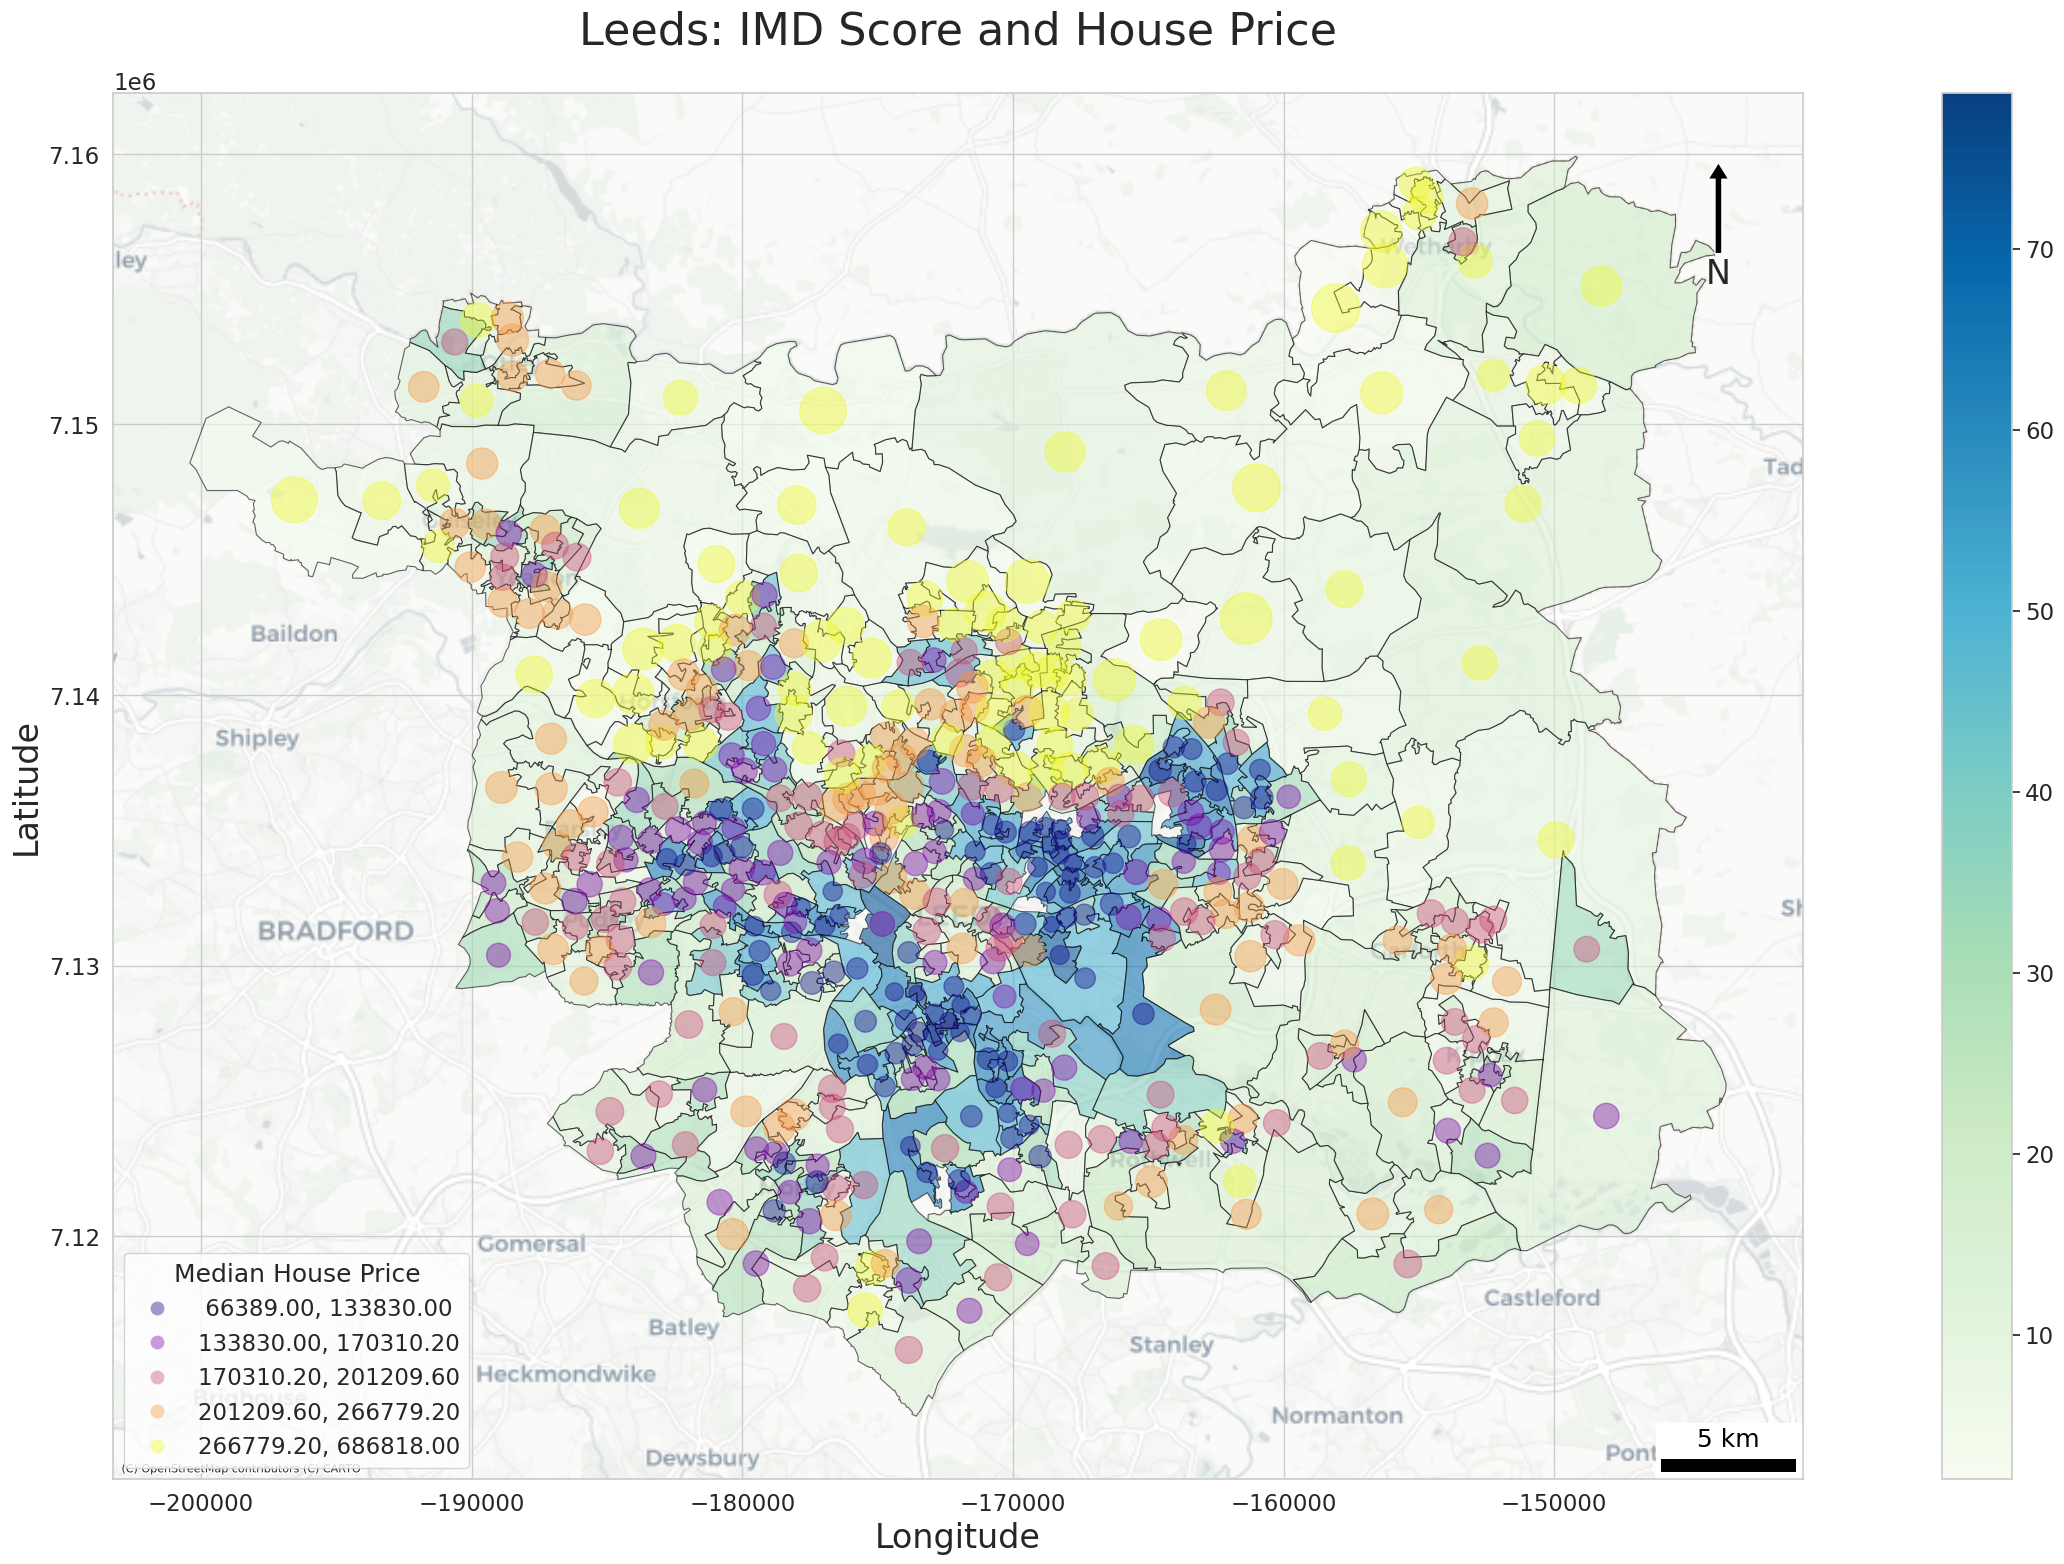

In [ ]:
# Set the coordinate reference system
merged_data = merged_data.to_crs(epsg=3857)
merged_data_centroid = merged_data_centroid.to_crs(epsg=3857)

# Creating plot frames
f, ax = plt.subplots(1, figsize=(36, 18))

# Plot choropleth map based on IMD Score
base = merged_data.plot(column='IMDScore', cmap='GnBu', alpha=0.6, linewidth=0.8, ax=ax, edgecolor='black', legend=True)

# Add CartoDB basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot proportional symbol map based on house price
merged_data_centroid.plot(
    ax=base,
    column='house_price',
    markersize=merged_data['house_price'] / 500,
    cmap='plasma',
    scheme='quantiles',
    alpha=0.4,
    legend=True,
    legend_kwds={'loc': 'lower left', 'title': 'Median House Price'}
)


# Add Scale

scalebar = ScaleBar(1, units="m", dimension="si-length", location='lower right', scale_loc='top', length_fraction=0.1, height_fraction=0.01, color='black')
ax.add_artist(scalebar)

# Add a North Pointer
x, y, arrow_length = 0.95, 0.95, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=24, xycoords=ax.transAxes)

# Set the legend and title
plt.title('Leeds: IMD Score and House Price', fontsize=32, y =1.03)
plt.xlabel('Longitude', fontsize=24)
plt.ylabel('Latitude', fontsize=24)

plt.show()

This map mainly references '5 Popular Thematic Map Types and Techniques for Spatial Data'{}. Firstly, we set the coordinate system to EPSG:3857 because it is compatible with web map services, it can be adapted to the basemap, and it is easy to add legends in meters. Secondly, CartoDB is set as the base map because it is lighter in color and the map elements are neat and tidy, which can highlight the spatial maps drawn.Plot choropleth map based on Plot IMD Score and the boundary line is black in order to display more intuitively the IMD Score of the different areas, which can help to identify the geographic distribution of the poverty level and spatial differences. Plot proportional symbol map and set point size based on house price is to directly reflect the level of house price by symbol size which is more intuitive and easy to compare visually. For color selection, the colormap of choropleth map and proportional symbols map are 'GnBu' and 'plasma', which are roughly complementary colors, they have high contrast and do not confuse the map colors, which helps to distinguish the color variations of the original map colors<a href="#ref9">[9]</a>. Added scale, north Pointer, legend and title to the map to make it more informative and accurate.

# References
<p><a href="https://www.tandfonline.com/doi/full/10.1080/02673037.2017.1291913?casa_token=KPtd8VYAnuAAAAAA%3ABQkVZ9JDrp4rnI-i2zH7Et27Nw5_DVpmCyPP_Re7Mz7ZX14-2Tzw-3icbstQttLAnHFxLpYkms4">[1]</a>Stephens, M. and Leishman, C. 2017. Housing and poverty: a longitudinal analysis. Housing Studies. 32(8), pp.1039–1061.</p>
<p><a href="https://link.springer.com/article/10.1007/s10901-021-09899-w">[2]</a>Bradbury, B. and Saunders, P. 2021. Housing costs and poverty: Analysing recent australian trends. Journal of Housing and the Built Environment. 37.</p>
<p><a href="https://journals.sagepub.com/doi/pdf/10.1177/1478210317736224">[3]</a>Ivinson, G., Thompson, I., Beckett, L., Egan, D., Leitch, R. and McKinney, S. 2017. Learning the price of poverty across the UK. Policy Futures in Education. 16(2), pp.130–143.</p>
<p><a href="https://data.cdrc.ac.uk/">[4]</a>Consumer Data Research Centre</p>
<p><a href="https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd">[5]</a>Index of Multiple Deprivation (IMD)</p>
<p><a href="https://davidmathlogic.com/colorblind/#%23FEFE62-%23D35FB7">[6]</a>Coloring for Colorblindness</p>
<p><a href="https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices">[7]</a>Dwelling Ages and Prices</p>
<p><a href="https://medium.com/@sawsanyusuf/data-visualization-with-python-8-regression-plots-9341cf2b9e96">[8]</a>Data Visualization with Python (8): Regression Plots</p>
<p><a href="https://blog.datawrapper.de/beautifulcolors/">[9]</a>How to pick more beautiful colors for your data visualizations</p>